# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Forward Volatility

In this notebook, we will create a forward volatility strategy on Nifty call option.

# Import the libraries

You can use the command <font color=red>!pip install mibian</font> to install the mibian library.

In [63]:
# To calculate implied volatility
import mibian as m

# For data manipulation and mathematical function
import pandas as pd
import numpy as np

# To plot
import matplotlib.pyplot as plt
import seaborn

# Importing data

We import the csv file containing the Nifty call option data. This data is taken from the NSE website. We store the data in the dataframe nifty_data.

In [64]:
# Read CSV
nifty_data=pd.read_csv("Nifty.csv")

# Convert the date fields into pandas datetime object
nifty_data.date=pd.to_datetime(nifty_data.date)
nifty_data.near_month_expiry=pd.to_datetime(nifty_data.near_month_expiry)
nifty_data.far_month_expiry=pd.to_datetime(nifty_data.far_month_expiry)

nifty_data.index=nifty_data.date

nifty_data.head()

,symbol,date,fut_near_month_close,fut_far_month_close,strike_price,near_month_expiry,LTP_near_month,far_month_expiry,LTP_far_month
date,,,,,,,,,
2017-08-28,NIFTY,2017-08-28,9950.80,9980.65,9800,2017-09-28,226.45,2017-10-26,293.6
2017-08-29,NIFTY,2017-08-29,9829.40,9860.15,9800,2017-09-28,150.80,2017-10-26,219.7
2017-08-30,NIFTY,2017-08-30,9912.45,9939.75,9800,2017-09-28,191.20,2017-10-26,259.7
2017-08-31,NIFTY,2017-08-31,9937.20,9963.35,9800,2017-09-28,201.85,2017-10-26,266.2
2017-09-01,NIFTY,2017-09-01,10007.30,10034.20,9800,2017-09-28,251.50,2017-10-26,312.3


# Time to expiry

We calculate the time to expiry for near_month and far_month contracts, and store it in near_month_days_to_expiry and far_month_days_to_expiry respectively.

In [65]:
nifty_data['near_month_days_to_expiry'] = (nifty_data.near_month_expiry - nifty_data.index).dt.days
nifty_data['far_month_days_to_expiry']= (nifty_data.far_month_expiry - nifty_data.index).dt.days
nifty_data.loc[:,['near_month_expiry','near_month_days_to_expiry','far_month_expiry','far_month_days_to_expiry']].head()

,near_month_expiry,near_month_days_to_expiry,far_month_expiry,far_month_days_to_expiry
date,,,,
2017-08-28,2017-09-28,31,2017-10-26,59
2017-08-29,2017-09-28,30,2017-10-26,58
2017-08-30,2017-09-28,29,2017-10-26,57
2017-08-31,2017-09-28,28,2017-10-26,56
2017-09-01,2017-09-28,27,2017-10-26,55


# Implied volatility (IV)

To calcualte the IV (implied volatility), we use the impliedVolatility function of the BS (Black Scholes) class in the mibian library. The input for this function is the futures close price, the strike price, the interest rate, the time to expiry in days, and the call price. 

Since we took futures price as underlying price, the interest rate is set to zero.

In [66]:
nifty_data['IV_near_month'] = 0
nifty_data['IV_far_month'] = 0

for row in range(len(nifty_data)):
    nifty_data.iloc[row,nifty_data.columns.get_loc('IV_near_month')] = m.BS( [
                 nifty_data.iloc[row]['fut_near_month_close'], \
                 nifty_data.iloc[row]['strike_price'], \
                 0, \
                 nifty_data.iloc[row]['near_month_days_to_expiry'] \
               ],
               callPrice = nifty_data.iloc[row]['LTP_near_month'] \
             ).impliedVolatility

    nifty_data.iloc[row,nifty_data.columns.get_loc('IV_far_month')] = m.BS( [
                 nifty_data.iloc[row]['fut_far_month_close'], \
                 nifty_data.iloc[row]['strike_price'], \
                 0, \
                 nifty_data.iloc[row]['far_month_days_to_expiry'] \
               ],
               callPrice = nifty_data.iloc[row]['LTP_far_month'] \
             ).impliedVolatility

# Forward volatility

In [67]:
# Calculate the variance for near month and far month
nifty_data['variance_near_month'] = (nifty_data.IV_near_month**2/365)*nifty_data.near_month_days_to_expiry
nifty_data['variance_far_month'] = (nifty_data.IV_far_month**2/365)*nifty_data.far_month_days_to_expiry
# Calculate the difference in far month and near month variance
nifty_data['variance_diff'] = nifty_data.variance_far_month - nifty_data.variance_near_month
nifty_data['forward_variance_days'] = nifty_data.far_month_days_to_expiry - nifty_data.near_month_days_to_expiry
# Calculate forward volatility from forward varinace
nifty_data['forward_volatility'] = (nifty_data.variance_diff*365/nifty_data.forward_variance_days)**0.5

Refer to the video on forward volatility for details on the above calculations.

# Trading signal

If forward volatility is more than near month volatility then it indicates that far month option is costlier when compared to near month option. Therefore, sell far month option and buy near month option. -1 is stored in the signal column to indicate this.

If forward volatility is less than near month volatility then we buy far month option and sell near month option. +1 is stored in the signal column to indicate this.

In [68]:
nifty_data['signal'] = np.where(nifty_data.forward_volatility > nifty_data.IV_near_month, -1, 1)
nifty_data.loc[:,['forward_volatility','IV_near_month','signal']].head()

,forward_volatility,IV_near_month,signal
date,,,
2017-08-28,11.884269,12.033463,1
2017-08-29,11.982315,12.077332,1
2017-08-30,11.836732,11.474609,-1
2017-08-31,11.218733,11.104584,-1
2017-09-01,10.958989,11.215210,1


# Strategy returns

Strategy returns are computed by taking difference between far month and near months returns.

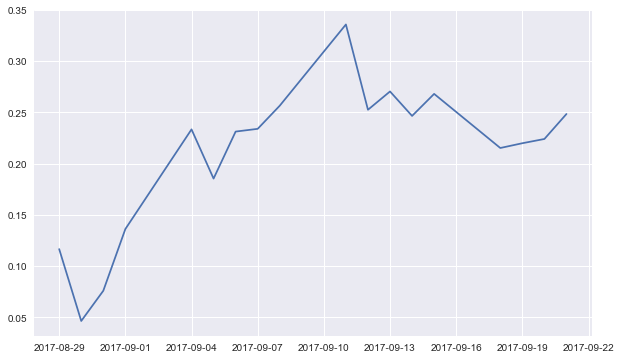

In [69]:
nifty_data['far_month_ret']= np.log(nifty_data.LTP_far_month/nifty_data.LTP_far_month.shift(1))
nifty_data['near_month_ret']= np.log(nifty_data.LTP_near_month/nifty_data.LTP_near_month.shift(1))
nifty_data['strategy_return'] = nifty_data.signal.shift(1) * (nifty_data.far_month_ret - nifty_data.near_month_ret)
plt.figure(figsize=(10,6))
plt.plot(nifty_data.strategy_return.cumsum())
plt.show()

The strategy yields close to 25% returns in a single month.